In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import HuberRegressor, LassoCV
import matplotlib.pyplot as plt

In [2]:
games_df = pd.read_csv('games.csv')
player_play_df = pd.read_csv('player_play.csv')
players_df = pd.read_csv('players.csv')
plays_df = pd.read_csv('plays.csv')
tracking_df = pd.read_csv('tracking_week_1.csv')

## Getting smaller csvs for GPT

In [3]:
#print size of player_play_df
print(player_play_df.shape)

# get a subset of player_play_df that is only 40% of the original size
player_play_df_subset = player_play_df.sample(frac=0.1)
print(player_play_df_subset.shape)

# save the subset to a new csv file
player_play_df_subset.to_csv('player_play_subset.csv', index=False)


(354727, 50)
(35473, 50)


In [4]:
#print size of tracking_df
print(tracking_df.shape)

# get a subset of tracking_df that is only 40% of the original size
tracking_df_subset = tracking_df.sample(frac=0.01)
print(tracking_df_subset.shape)

# save the subset to a new csv file
tracking_df_subset.to_csv('tracking_subset.csv', index=False)


(7104700, 18)
(71047, 18)


In [5]:
# print columns of player_play_df
print(player_play_df.columns)

Index(['gameId', 'playId', 'nflId', 'teamAbbr', 'hadRushAttempt',
       'rushingYards', 'hadDropback', 'passingYards', 'sackYardsAsOffense',
       'hadPassReception', 'receivingYards', 'wasTargettedReceiver',
       'yardageGainedAfterTheCatch', 'fumbles', 'fumbleLost',
       'fumbleOutOfBounds', 'assistedTackle', 'forcedFumbleAsDefense',
       'halfSackYardsAsDefense', 'passDefensed', 'quarterbackHit',
       'sackYardsAsDefense', 'safetyAsDefense', 'soloTackle', 'tackleAssist',
       'tackleForALoss', 'tackleForALossYardage', 'hadInterception',
       'interceptionYards', 'fumbleRecoveries', 'fumbleRecoveryYards',
       'penaltyYards', 'penaltyNames', 'wasInitialPassRusher',
       'causedPressure', 'timeToPressureAsPassRusher',
       'getOffTimeAsPassRusher', 'inMotionAtBallSnap', 'shiftSinceLineset',
       'motionSinceLineset', 'wasRunningRoute', 'routeRan',
       'blockedPlayerNFLId1', 'blockedPlayerNFLId2', 'blockedPlayerNFLId3',
       'pressureAllowedAsBlocker', 'timeT

# Feature Extraction: Player Performance (Nominal)

In [6]:
def calculate_player_metrics(player_play_df, plays_df):
    """
    Calculate offensive and defensive metrics for each player
    """
    # Join dataframes
    merged_df = player_play_df.merge(plays_df, on=['gameId', 'playId'])
    
    # First, let's verify which columns exist
    print("Available columns:", merged_df.columns.tolist())
    
    # Calculate offensive metrics
    offensive_stats = merged_df.groupby('nflId').agg({
        'hadPassReception': 'sum',
        'receivingYards': 'sum',
        'wasTargettedReceiver': 'sum',
        'hadRushAttempt': 'sum',
        'rushingYards': 'sum',
        'passingYards': 'sum',
        'expectedPointsAdded': 'sum',
        'pressureAllowedAsBlocker': 'sum',
        'timeToPressureAllowedAsBlocker': 'mean'
    }).fillna(0)
    
    # Calculate defensive metrics - removing 'interception' for now
    defensive_stats = merged_df.groupby('nflId').agg({
        'tackleForALoss': 'sum',
        'sackYardsAsDefense': 'sum',
        'passDefensed': 'sum',
        'quarterbackHit': 'sum',
        'tackleAssist': 'sum',
        'soloTackle': 'sum'
    }).fillna(0)
    
    return offensive_stats, defensive_stats

def create_player_score(offensive_stats, defensive_stats, players_df):
    """
    Create composite player scores based on position-specific weights
    """
    def normalize(series):
        if series.max() == series.min():
            return series * 0
        return (series - series.min()) / (series.max() - series.min())
    
    # Position-specific weights
    position_weights = {
        # Offensive positions
        'QB': {
            'expectedPointsAdded': 0.6,
            'passingYards': 0.4
        },
        'WR': {
            'expectedPointsAdded': 0.4,
            'receivingYards': 0.3,
            'wasTargettedReceiver': 0.3
        },
        'RB': {
            'expectedPointsAdded': 0.5,
            'rushingYards': 0.5
        },
        'TE': {
            'expectedPointsAdded': 0.4,
            'receivingYards': 0.3,
            'hadPassReception': 0.3
        },
        'FB': {
            'expectedPointsAdded': 0.4,
            'rushingYards': 0.3,
            'tackleAssist': 0.3
        },
        'G': {
            'expectedPointsAdded': 0.4,
            'pressureAllowedAsBlocker': -0.3,
            'timeToPressureAllowedAsBlocker': 0.3
        },
        'C': {
            'expectedPointsAdded': 0.4,
            'pressureAllowedAsBlocker': -0.3,
            'timeToPressureAllowedAsBlocker': 0.3
        },
        'T': {
            'expectedPointsAdded': 0.4,
            'pressureAllowedAsBlocker': -0.3,
            'timeToPressureAllowedAsBlocker': 0.3
        },
        # Defensive positions
        'DB': {
            'passDefensed': 0.4,
            'tackleForALoss': 0.3,
            'soloTackle': 0.3
        },
        'CB': {
            'passDefensed': 0.5,
            'soloTackle': 0.3,
            'tackleForALoss': 0.2
        },
        'FS': {
            'tackleForALoss': 0.3,
            'passDefensed': 0.4,
            'soloTackle': 0.3
        },
        'SS': {
            'soloTackle': 0.4,
            'passDefensed': 0.3,
            'tackleForALoss': 0.3
        },
        'ILB': {
            'soloTackle': 0.4,
            'tackleForALoss': 0.3,
            'tackleAssist': 0.3
        },
        'LB': {
            'soloTackle': 0.4,
            'tackleForALoss': 0.3,
            'quarterbackHit': 0.3
        },
        'MLB': {
            'soloTackle': 0.4,
            'tackleForALoss': 0.3,
            'tackleAssist': 0.3
        },
        'OLB': {
            'sackYardsAsDefense': 0.4,
            'tackleForALoss': 0.3,
            'quarterbackHit': 0.3
        },
        'DE': {
            'sackYardsAsDefense': 0.4,
            'quarterbackHit': 0.3,
            'tackleForALoss': 0.3
        },
        'DT': {
            'tackleForALoss': 0.4,
            'sackYardsAsDefense': 0.3,
            'quarterbackHit': 0.3
        },
        'NT': {
            'tackleForALoss': 0.5,
            'soloTackle': 0.5
        }
    }
    
    # Create DataFrame for scores
    scores_df = pd.DataFrame(index=offensive_stats.index, columns=['player_score'])
    scores_df['player_score'] = 0
    
    # Calculate composite score based on position
    for nflId in scores_df.index:
        player_info = players_df[players_df['nflId'] == nflId]
        if len(player_info) > 0:
            player_position = player_info['position'].iloc[0]
            if player_position in position_weights:
                metrics = position_weights[player_position]
                player_score = 0
                for metric, weight in metrics.items():
                    if metric in offensive_stats.columns:
                        player_score += normalize(offensive_stats[metric])[nflId] * weight
                    elif metric in defensive_stats.columns:
                        player_score += normalize(defensive_stats[metric])[nflId] * weight
                scores_df.loc[nflId, 'player_score'] = player_score
    
    return scores_df

def get_top_performers(player_scores, players_df, n=10):
    """
    Get the top n performing players with their details
    """
    top_performers = players_df.merge(
        player_scores,
        left_on='nflId',
        right_index=True
    ).sort_values('player_score', ascending=False).head(n)
    
    return top_performers

def add_player_features(tracking_df, player_scores):
    """
    Add player score to tracking data
    """
    enhanced_df = tracking_df.merge(player_scores, left_on='nflId', right_index=True, how='left')
    enhanced_df['player_score'] = enhanced_df['player_score'].fillna(0)
    return enhanced_df

In [7]:
# 1. First calculate player metrics
offensive_stats, defensive_stats = calculate_player_metrics(player_play_df, plays_df)

# 2. Create player scores
player_scores = create_player_score(offensive_stats, defensive_stats, players_df)

# 3. Get top performers to verify the scoring
top_players = get_top_performers(player_scores, players_df, n=15)
print("\nTop 15 Players:")
print(top_players[['displayName', 'position', 'player_score']].to_string())

Available columns: ['gameId', 'playId', 'nflId', 'teamAbbr', 'hadRushAttempt', 'rushingYards', 'hadDropback', 'passingYards', 'sackYardsAsOffense', 'hadPassReception', 'receivingYards', 'wasTargettedReceiver', 'yardageGainedAfterTheCatch', 'fumbles', 'fumbleLost', 'fumbleOutOfBounds', 'assistedTackle', 'forcedFumbleAsDefense', 'halfSackYardsAsDefense', 'passDefensed', 'quarterbackHit', 'sackYardsAsDefense', 'safetyAsDefense', 'soloTackle', 'tackleAssist', 'tackleForALoss', 'tackleForALossYardage', 'hadInterception', 'interceptionYards', 'fumbleRecoveries', 'fumbleRecoveryYards', 'penaltyYards_x', 'penaltyNames', 'wasInitialPassRusher', 'causedPressure', 'timeToPressureAsPassRusher', 'getOffTimeAsPassRusher', 'inMotionAtBallSnap', 'shiftSinceLineset', 'motionSinceLineset', 'wasRunningRoute', 'routeRan', 'blockedPlayerNFLId1', 'blockedPlayerNFLId2', 'blockedPlayerNFLId3', 'pressureAllowedAsBlocker', 'timeToPressureAllowedAsBlocker', 'pff_defensiveCoverageAssignment', 'pff_primaryDefensiv

C:\Users\jwpin\AppData\Local\Temp\ipykernel_11180\1561618113.py:160: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5823648403845709' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  scores_df.loc[nflId, 'player_score'] = player_score



Top 15 Players:
              displayName position  player_score
417       Patrick Mahomes       QB      0.999761
367           Tyreek Hill       WR      0.902728
1043          Jalen Hurts       QB      0.808087
93           Travis Kelce       TE      0.800993
316         Derrick Henry       RB      0.791608
1001       Tua Tagovailoa       QB      0.789090
569            Josh Allen       QB      0.788692
998            Joe Burrow       QB      0.770332
595            Nick Chubb       RB      0.758711
255          Stefon Diggs       WR      0.756506
1234        Jaylen Waddle       WR      0.755545
1252       Travis Etienne       RB      0.751669
791           Josh Jacobs       RB      0.741727
1229      Trevor Lawrence       QB      0.724651
456   JuJu Smith-Schuster       WR      0.716379


In [8]:
# 4. Add scores to tracking data
enhanced_tracking = add_player_features(tracking_df, player_scores)

# Optional: View distribution of scores by position
position_scores = players_df.merge(
    player_scores, 
    left_on='nflId', 
    right_index=True
).groupby('position')['player_score'].agg(['mean', 'count', 'std'])
print("\nScore Distribution by Position:")
print(position_scores.sort_values('mean', ascending=False))

# save the player scores to a new csv file
player_scores.to_csv('player_scores.csv')

# Optional: Save enhanced tracking data
# enhanced_tracking.to_csv('enhanced_tracking.csv', index=False)


Score Distribution by Position:
              mean  count       std
position                           
QB        0.449905     62  0.165718
DE        0.445437    131  0.061627
LB        0.438989      1       NaN
OLB       0.435895    135  0.053876
RB        0.375319    126  0.136005
DT        0.353880    121  0.067252
WR        0.320994    224  0.133026
TE        0.275391    123  0.097317
ILB       0.260609     93  0.212822
MLB       0.260020     16  0.197267
FB        0.220570     14  0.024150
C         0.211682     61  0.077074
G         0.196181    107  0.089842
SS        0.189047     65  0.150504
T         0.179349    117  0.096254
CB        0.175477    189  0.152233
FS        0.131153     79  0.119250
NT        0.108904     32  0.102678
DB        0.041176      1       NaN


In [9]:
# print the names of the CBs from the player_scores dataframe witht the highest player_score
print(player_scores[player_scores.index.isin(players_df[players_df['position'] == 'CB']['nflId'])].sort_values('player_score', ascending=False).head(10))

# print the names of player with NFLID 54469
print(players_df[players_df['nflId'] == 43294])


       player_score
nflId              
54469      0.693213
43294      0.551131
43351      0.528959
47941      0.515385
37078      0.496380
52459      0.481448
46211      0.472851
44964      0.466063
54618      0.464253
53462      0.461086
     nflId height  weight   birthDate    collegeName position   displayName
292  43294    6-1     208  1994-10-24  Florida State       CB  Jalen Ramsey


In [10]:
# print how many players have a score of 0 from the player_scores dataframe
print(player_scores[player_scores['player_score'] == 0].shape[0])

50


In [11]:
# print the unique positions from the position_scores dataframe
print(position_scores.index.unique())

# print the number of positions from the position_scores dataframe
print(position_scores.shape[0])

Index(['C', 'CB', 'DB', 'DE', 'DT', 'FB', 'FS', 'G', 'ILB', 'LB', 'MLB', 'NT',
       'OLB', 'QB', 'RB', 'SS', 'T', 'TE', 'WR'],
      dtype='object', name='position')
19


## Adding Robustness to Uncertainty

In [12]:
from sklearn.model_selection import KFold

In [13]:
def create_position_specific_features(player_play_df, plays_df, players_df, position):
    """
    Create position-specific features using only available columns
    """
    merged_df = player_play_df.merge(plays_df, on=['gameId', 'playId'])
    merged_df = merged_df.merge(players_df[['nflId', 'position']], on='nflId')
    
    # Feature sets using only available columns from your data
    feature_sets = {
        'QB': ['passingYards', 'expectedPointsAdded'],
        'WR': ['receivingYards', 'hadPassReception', 'wasTargettedReceiver'],
        'RB': ['rushingYards', 'hadRushAttempt', 'expectedPointsAdded'],
        'TE': ['receivingYards', 'hadPassReception', 'wasTargettedReceiver'],
        'FB': ['rushingYards', 'hadRushAttempt', 'tackleAssist'],
        'G': ['pressureAllowedAsBlocker', 'timeToPressureAllowedAsBlocker', 'expectedPointsAdded'],
        'C': ['pressureAllowedAsBlocker', 'timeToPressureAllowedAsBlocker', 'expectedPointsAdded'],
        'T': ['pressureAllowedAsBlocker', 'timeToPressureAllowedAsBlocker', 'expectedPointsAdded'],
        'DB': ['passDefensed', 'tackleForALoss', 'soloTackle'],
        'CB': ['passDefensed', 'soloTackle', 'tackleForALoss'],
        'FS': ['tackleForALoss', 'passDefensed', 'soloTackle'],
        'SS': ['soloTackle', 'passDefensed', 'tackleForALoss'],
        'ILB': ['soloTackle', 'tackleForALoss', 'tackleAssist'],
        'LB': ['soloTackle', 'tackleForALoss', 'quarterbackHit'],
        'MLB': ['soloTackle', 'tackleForALoss', 'tackleAssist'],
        'OLB': ['sackYardsAsDefense', 'tackleForALoss', 'quarterbackHit'],
        'DE': ['sackYardsAsDefense', 'quarterbackHit', 'tackleForALoss'],
        'DT': ['tackleForALoss', 'sackYardsAsDefense', 'quarterbackHit'],
        'NT': ['tackleForALoss', 'soloTackle', 'tackleAssist']
    }
    
    pos_df = merged_df[merged_df['position'] == position]
    features = pos_df.groupby('nflId')[feature_sets[position]].agg('sum').fillna(0)
    
    return features

def train_position_models(player_play_df, plays_df, players_df, player_scores, positions):
    """
    Train robust regression models with regularization for each position
    """
    models = {}
    metrics = {}
    
    for position in positions:
        X = create_position_specific_features(player_play_df, plays_df, players_df, position)
        
        # Get player scores for this position
        position_players = players_df[players_df['position'] == position]['nflId']
        y = player_scores.loc[position_players]['player_score']
        
        # Align X and y
        common_index = X.index.intersection(y.index)
        X = X.loc[common_index]
        y = y.loc[common_index]
        
        if len(X) < 2:
            continue
            
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Use 5-fold cross validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        train_scores = []
        test_scores = []
        
        for train_idx, test_idx in kf.split(X_scaled):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Train robust regression with increased epsilon for more robustness
            model = HuberRegressor(epsilon=2.0, alpha=0.1)
            model.fit(X_train, y_train)
            
            train_scores.append(model.score(X_train, y_train))
            test_scores.append(model.score(X_test, y_test))
        
        models[position] = {
            'model': model,
            'scaler': scaler,
            'features': X.columns.tolist()
        }
        
        metrics[position] = {
            'train_r2': np.mean(train_scores),
            'test_r2': np.mean(test_scores),
            'train_r2_std': np.std(train_scores),
            'test_r2_std': np.std(test_scores),
            'n_samples': len(X)
        }
    
    return models, metrics

# Run the models and print detailed results
def print_model_performance(metrics):
    print("\nDetailed Model Performance by Position:")
    print("----------------------------------------")
    for position in sorted(metrics.keys()):
        print(f"\nPosition: {position}")
        print(f"Number of players: {metrics[position]['n_samples']}")
        print(f"Training R² (mean): {metrics[position]['train_r2']:.3f} (±{metrics[position]['train_r2_std']:.3f})")
        print(f"Testing R² (mean): {metrics[position]['test_r2']:.3f} (±{metrics[position]['test_r2_std']:.3f})")

# Run the models
positions = ['C', 'CB', 'DB', 'DE', 'DT', 'FB', 'FS', 'G', 'ILB', 'LB', 
            'MLB', 'NT', 'OLB', 'QB', 'RB', 'SS', 'T', 'TE', 'WR']

# Train models and get metrics
position_models, position_metrics = train_position_models(
    player_play_df, plays_df, players_df, player_scores, positions
)

# Print detailed results
print_model_performance(position_metrics)

# Print summary statistics
print("\nSummary Statistics:")
print("------------------")
test_r2s = [metrics['test_r2'] for metrics in position_metrics.values()]
print(f"Average Test R² across positions: {np.mean(test_r2s):.3f}")
print(f"Best performing position: {max(position_metrics.items(), key=lambda x: x[1]['test_r2'])[0]}")
print(f"Most players in position: {max(position_metrics.items(), key=lambda x: x[1]['n_samples'])[0]}")


Detailed Model Performance by Position:
----------------------------------------

Position: C
Number of players: 61
Training R² (mean): 0.882 (±0.009)
Testing R² (mean): 0.784 (±0.099)

Position: CB
Number of players: 189
Training R² (mean): 1.000 (±0.000)
Testing R² (mean): 1.000 (±0.000)

Position: DE
Number of players: 131
Training R² (mean): 1.000 (±0.000)
Testing R² (mean): 1.000 (±0.000)

Position: DT
Number of players: 121
Training R² (mean): 1.000 (±0.000)
Testing R² (mean): 1.000 (±0.000)

Position: FB
Number of players: 14
Training R² (mean): 0.276 (±0.103)
Testing R² (mean): -1.656 (±1.182)

Position: FS
Number of players: 79
Training R² (mean): 1.000 (±0.000)
Testing R² (mean): 1.000 (±0.000)

Position: G
Number of players: 107
Training R² (mean): 0.909 (±0.016)
Testing R² (mean): 0.874 (±0.121)

Position: ILB
Number of players: 93
Training R² (mean): 1.000 (±0.000)
Testing R² (mean): 1.000 (±0.000)

Position: MLB
Number of players: 16
Training R² (mean): 1.000 (±0.000)
Te

## Attempt 2

In [14]:
def create_position_specific_features(player_play_df, plays_df, players_df, position):
    """
    Create position-specific features using only available columns
    """
    merged_df = player_play_df.merge(plays_df, on=['gameId', 'playId'])
    merged_df = merged_df.merge(players_df[['nflId', 'position']], on='nflId')
    
    # Keep existing feature sets
    feature_sets = {
        'QB': ['passingYards', 'expectedPointsAdded'],
        'WR': ['receivingYards', 'hadPassReception', 'wasTargettedReceiver'],
        'RB': ['rushingYards', 'hadRushAttempt', 'expectedPointsAdded'],
        'TE': ['receivingYards', 'hadPassReception', 'wasTargettedReceiver'],
        'FB': ['rushingYards', 'hadRushAttempt', 'tackleAssist'],
        'G': ['pressureAllowedAsBlocker', 'timeToPressureAllowedAsBlocker', 'expectedPointsAdded'],
        'C': ['pressureAllowedAsBlocker', 'timeToPressureAllowedAsBlocker', 'expectedPointsAdded'],
        'T': ['pressureAllowedAsBlocker', 'timeToPressureAllowedAsBlocker', 'expectedPointsAdded'],
        'DB': ['passDefensed', 'tackleForALoss', 'soloTackle'],
        'CB': ['passDefensed', 'soloTackle', 'tackleForALoss'],
        'FS': ['tackleForALoss', 'passDefensed', 'soloTackle'],
        'SS': ['soloTackle', 'passDefensed', 'tackleForALoss'],
        'ILB': ['soloTackle', 'tackleForALoss', 'tackleAssist'],
        'LB': ['soloTackle', 'tackleForALoss', 'quarterbackHit'],
        'MLB': ['soloTackle', 'tackleForALoss', 'tackleAssist'],
        'OLB': ['sackYardsAsDefense', 'tackleForALoss', 'quarterbackHit'],
        'DE': ['sackYardsAsDefense', 'quarterbackHit', 'tackleForALoss'],
        'DT': ['tackleForALoss', 'sackYardsAsDefense', 'quarterbackHit'],
        'NT': ['tackleForALoss', 'soloTackle', 'tackleAssist']
    }
    
    pos_df = merged_df[merged_df['position'] == position]
    features = pos_df.groupby('nflId')[feature_sets[position]].agg('sum').fillna(0)
    
    return features

def train_position_models(player_play_df, plays_df, players_df, player_scores, positions):
    """
    Train robust regression models with adaptive cross-validation and increased regularization
    """
    from sklearn.model_selection import LeaveOneOut
    
    models = {}
    metrics = {}
    
    for position in positions:
        X = create_position_specific_features(player_play_df, plays_df, players_df, position)
        
        position_players = players_df[players_df['position'] == position]['nflId']
        y = player_scores.loc[position_players]['player_score']
        
        common_index = X.index.intersection(y.index)
        X = X.loc[common_index]
        y = y.loc[common_index]
        
        if len(X) < 2:
            continue
            
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Adaptive cross-validation based on sample size
        if len(X) < 10:  # For very small samples
            cv = LeaveOneOut()
        elif len(X) < 30:  # For small samples
            cv = KFold(n_splits=3, shuffle=True, random_state=42)
        elif len(X) < 50:  # For medium samples
            cv = KFold(n_splits=5, shuffle=True, random_state=42)
        else:  # For large samples
            cv = KFold(n_splits=10, shuffle=True, random_state=42)
        
        train_scores = []
        test_scores = []
        
        for train_idx, test_idx in cv.split(X_scaled):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Increased regularization
            model = HuberRegressor(epsilon=1.5, alpha=0.5)  # Increased alpha for stronger regularization
            model.fit(X_train, y_train)
            
            train_scores.append(model.score(X_train, y_train))
            test_scores.append(model.score(X_test, y_test))
        
        models[position] = {
            'model': model,
            'scaler': scaler,
            'features': X.columns.tolist()
        }
        
        metrics[position] = {
            'train_r2': np.mean(train_scores),
            'test_r2': np.mean(test_scores),
            'train_r2_std': np.std(train_scores),
            'test_r2_std': np.std(test_scores),
            'n_samples': len(X),
            'cv_type': 'LOO' if len(X) < 10 else f'{cv.n_splits}-fold'
        }
    
    return models, metrics

def print_model_performance(metrics):
    print("\nDetailed Model Performance by Position:")
    print("----------------------------------------")
    for position in sorted(metrics.keys()):
        print(f"\nPosition: {position}")
        print(f"Number of players: {metrics[position]['n_samples']}")
        print(f"CV Type: {metrics[position]['cv_type']}")
        print(f"Training R² (mean): {metrics[position]['train_r2']:.3f} (±{metrics[position]['train_r2_std']:.3f})")
        print(f"Testing R² (mean): {metrics[position]['test_r2']:.3f} (±{metrics[position]['test_r2_std']:.3f})")


Model Performance by Position:

Position: C (Total Players: 61)
Training Sample Size: 61
Training R²: 0.847 (±0.016)
Testing R²: 0.177 (±1.384)

Position: CB (Total Players: 189)
Training Sample Size: 189
Training R²: 1.000 (±0.000)
Testing R²: 1.000 (±0.000)

Position: DE (Total Players: 131)
Training Sample Size: 131
Training R²: 1.000 (±0.000)
Testing R²: 1.000 (±0.000)

Position: DT (Total Players: 121)
Training Sample Size: 121
Training R²: 1.000 (±0.000)
Testing R²: 1.000 (±0.000)

Position: FB (Total Players: 14)
Training Sample Size: 14
Training R²: 0.218 (±0.031)
Testing R²: -1.810 (±0.759)

Position: FS (Total Players: 79)
Training Sample Size: 79
Training R²: 1.000 (±0.000)
Testing R²: 1.000 (±0.000)

Position: G (Total Players: 107)
Training Sample Size: 107
Training R²: 0.902 (±0.010)
Testing R²: 0.848 (±0.176)

Position: ILB (Total Players: 93)
Training Sample Size: 93
Training R²: 1.000 (±0.000)
Testing R²: 1.000 (±0.000)

Position: MLB (Total Players: 16)
Training Samp

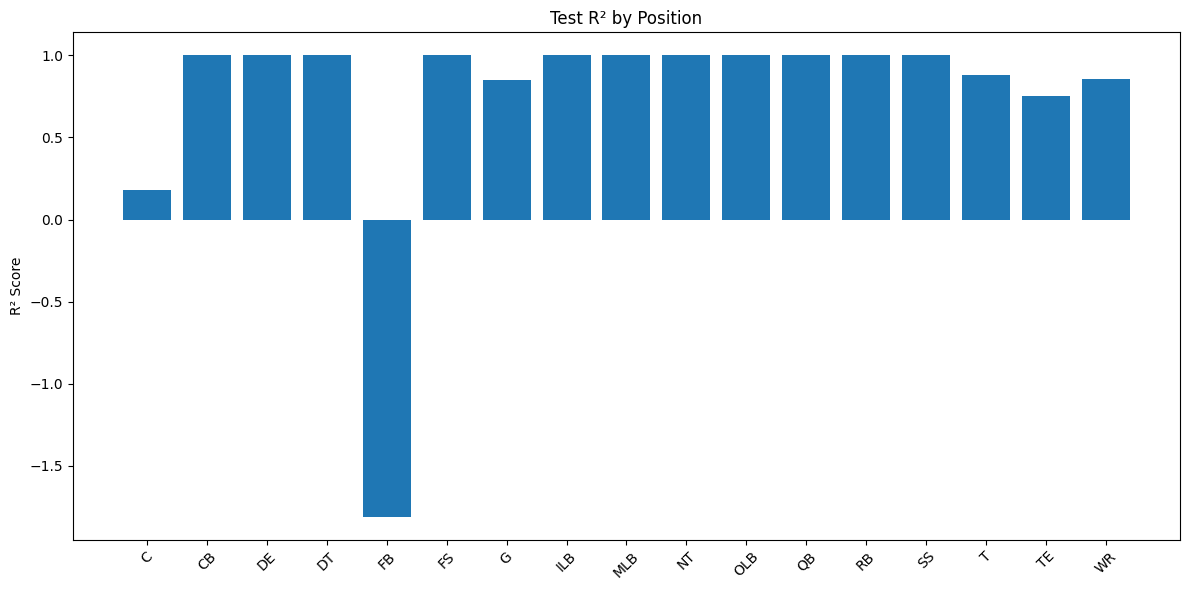

In [15]:
# Import additional required libraries
from sklearn.model_selection import KFold
import numpy as np

def print_position_results(metrics, players_df):
    """
    Print detailed performance metrics by position with player counts
    """
    print("\nModel Performance by Position:")
    print("=" * 50)
    
    for position in sorted(metrics.keys()):
        # Get number of players in this position
        position_count = len(players_df[players_df['position'] == position])
        
        print(f"\nPosition: {position} (Total Players: {position_count})")
        print(f"Training Sample Size: {metrics[position]['n_samples']}")
        print(f"Training R²: {metrics[position]['train_r2']:.3f} (±{metrics[position]['train_r2_std']:.3f})")
        print(f"Testing R²: {metrics[position]['test_r2']:.3f} (±{metrics[position]['test_r2_std']:.3f})")

# Run the models
positions = ['C', 'CB', 'DB', 'DE', 'DT', 'FB', 'FS', 'G', 'ILB', 'LB', 
            'MLB', 'NT', 'OLB', 'QB', 'RB', 'SS', 'T', 'TE', 'WR']

# Train models and get metrics
position_models, position_metrics = train_position_models(
    player_play_df, plays_df, players_df, player_scores, positions
)

# Print detailed results
print_position_results(position_metrics, players_df)

# Print summary statistics
print("\nSummary Statistics")
print("=" * 50)
test_r2s = [metrics['test_r2'] for metrics in position_metrics.values()]
print(f"Average Test R² across positions: {np.mean(test_r2s):.3f}")
print(f"Best performing position: {max(position_metrics.items(), key=lambda x: x[1]['test_r2'])[0]}")
print(f"Worst performing position: {min(position_metrics.items(), key=lambda x: x[1]['test_r2'])[0]}")
print(f"Position with most samples: {max(position_metrics.items(), key=lambda x: x[1]['n_samples'])[0]}")

# Optional: Plot R² distributions
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
positions = sorted(position_metrics.keys())
test_r2s = [position_metrics[pos]['test_r2'] for pos in positions]
plt.bar(positions, test_r2s)
plt.title('Test R² by Position')
plt.xticks(rotation=45)
plt.ylabel('R² Score')
plt.tight_layout()
plt.show()

In [16]:
# print positions who did not have a test r2 of 1.0
print([pos for pos in position_metrics if position_metrics[pos]['test_r2'] != 1.0])

['C', 'DT', 'FB', 'G', 'MLB', 'NT', 'QB', 'SS', 'T', 'TE', 'WR']


In [17]:
# print class type of position_metrics
print(type(position_metrics))

<class 'dict'>


In [18]:
for key in position_metrics:
    print(key, '->', position_metrics[key])

C -> {'train_r2': np.float64(0.8467099792793273), 'test_r2': np.float64(0.17749639125547273), 'train_r2_std': np.float64(0.01568246803029382), 'test_r2_std': np.float64(1.384248040330992), 'n_samples': 61, 'cv_type': '10-fold'}
CB -> {'train_r2': np.float64(1.0), 'test_r2': np.float64(1.0), 'train_r2_std': np.float64(0.0), 'test_r2_std': np.float64(0.0), 'n_samples': 189, 'cv_type': '10-fold'}
DE -> {'train_r2': np.float64(1.0), 'test_r2': np.float64(1.0), 'train_r2_std': np.float64(0.0), 'test_r2_std': np.float64(3.510833468576701e-17), 'n_samples': 131, 'cv_type': '10-fold'}
DT -> {'train_r2': np.float64(0.9999999999999829), 'test_r2': np.float64(0.9999999999999781), 'train_r2_std': np.float64(5.0526029074151116e-14), 'test_r2_std': np.float64(6.504497205138362e-14), 'n_samples': 121, 'cv_type': '10-fold'}
FB -> {'train_r2': np.float64(0.21771009896909443), 'test_r2': np.float64(-1.8095130478039974), 'train_r2_std': np.float64(0.03141694893466827), 'test_r2_std': np.float64(0.7586595

## Making New Dataframe

In [ ]:
# Create a copy of the original player_scores dataframe
robust_player_scores = player_scores.copy()

# List of positions to update
positions_to_update = ['C', 'G', 'T', 'TE', 'WR']

for position in positions_to_update:
    # Get players of current position
    position_players = players_df[players_df['position'] == position]['nflId']
    
    # Get features for this position
    X = create_position_specific_features(player_play_df, plays_df, players_df, position)
    
    # Get player scores for this position
    y = player_scores.loc[position_players]['player_score']
    
    # Align X and y
    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]
    
    if len(X) < 2:
        continue
        
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train robust regression model
    model = HuberRegressor(epsilon=1.5, alpha=0.5)
    model.fit(X_scaled, y)
    
    # Predict new scores
    predicted_scores = model.predict(X_scaled)
    
    # Update scores in robust_player_scores
    robust_player_scores.loc[common_index, 'player_score'] = predicted_scores

# Optional: Print comparison of scores for a position
for position in positions_to_update:
    position_players = players_df[players_df['position'] == position]['nflId']
    print(f"\n{position} Score Comparison:")
    comparison = pd.DataFrame({
        'Original': player_scores.loc[position_players]['player_score'],
        'Robust': robust_player_scores.loc[position_players]['player_score']
    })
    print(comparison.head()
          
          )
    






C Score Comparison:
       Original    Robust
nflId                    
37130  0.265114  0.259113
37266  0.378189  0.375773
38629  0.204097  0.202427
41069  0.197612  0.181893
41293  0.307310  0.261120

G Score Comparison:
       Original    Robust
nflId                    
35472  0.296295  0.295295
38557  0.288940  0.281346
39684  0.314144  0.282875
39965  0.259575  0.263209
40089  0.254608  0.253380

T Score Comparison:
       Original    Robust
nflId                    
29550  0.280429  0.276059
33107  0.197887  0.192278
35443  0.192542  0.191681
36785  0.209181  0.291909
37213  0.249488  0.245752

TE Score Comparison:
       Original    Robust
nflId                    
30842  0.196759  0.223239
37118  0.197145  0.205516
39983  0.489980  0.474690
40011  0.800993  0.656806
40149  0.223886  0.215480

WR Score Comparison:
       Original    Robust
nflId                    
33130  0.225310  0.220409
33234  0.213792  0.210774
37077  0.283060  0.242630
37079  0.305088  0.286143
37139  0.

In [22]:
# print count of players of each position in the player_scores dataframe
print(players_df.groupby('position').size())

# sum the player cont of WR, C, G, TE, and T in the players_df dataframe   
print(players_df.groupby('position').size()[['WR', 'C', 'G', 'TE', 'T']].sum())

position
C       61
CB     189
DB       1
DE     131
DT     121
FB      14
FS      79
G      107
ILB     93
LB       1
MLB     16
NT      32
OLB    135
QB      62
RB     126
SS      65
T      117
TE     123
WR     224
dtype: int64
632


In [23]:
# count the number of different values between the original and robust player scores
print(robust_player_scores['player_score'].ne(player_scores['player_score']).sum())

632


In [24]:
# save the robust_player_scores to a new csv file
robust_player_scores.to_csv('robust_player_scores.csv')